In [1]:
pip install timm opencv-python matplotlib


Note: you may need to restart the kernel to use updated packages.


Using cache found in /Users/orsuvinay/.cache/torch/hub/intel-isl_MiDaS_master
/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /Users/orsuvinay/.cache/torch/hub/intel-isl_MiDaS_master


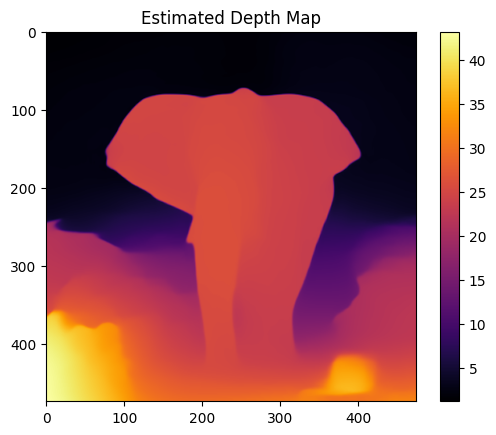

In [2]:
import torch
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load MiDaS model from PyTorch Hub
model_type = "DPT_Large"  # or "DPT_Hybrid" for faster
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

# Load transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform if "DPT" in model_type else midas_transforms.small_transform

# Load input image
img_path = "/Users/orsuvinay/Downloads/Deep Learning projects/OIP.jpeg"
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img_rgb).to(device)

# Predict depth
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = prediction.cpu().numpy()

# Visualize
plt.imshow(depth_map, cmap='inferno')
plt.colorbar()
plt.title("Estimated Depth Map") 
plt.show()


In [3]:
!pip install open3d


In [ ]:
import open3d as o3d

# Resize RGB to match depth map
img_rgb_resized = cv2.resize(img_rgb, (depth_map.shape[1], depth_map.shape[0]))

# Normalize depth
depth = depth_map / depth_map.max()

# Convert depth and RGB to Open3D images
depth_o3d = o3d.geometry.Image((depth * 1000).astype(np.uint16))  # convert to mm scale
color_o3d = o3d.geometry.Image(img_rgb_resized)

# Create Open3D RGBD image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d, depth_o3d,
    convert_rgb_to_intensity=False
)

# Define camera intrinsic parameters (can be fine-tuned)
width, height = depth_map.shape[1], depth_map.shape[0]
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width, height,
    fx=width, fy=height, cx=width / 2, cy=height / 2
)

# Generate point cloud
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)

# Flip for proper orientation
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

# Visualize
o3d.visualization.draw_geometries([pcd])


: 